# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# import sqlite3
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

### Reading data from Reviews.csv using Google Drive

In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download a file based on its file ID
downloaded = drive.CreateFile({'id':'1lO2D1dVr4jU_jQ7yMLlXdVOJih6sE-g-'})
downloaded.GetContentFile('Reviews.csv') 

# [1]. Reading Data

In [145]:
data = pd.read_csv('Reviews.csv')

filtered_data = data[data['Score'] != 3]

filtered_data = filtered_data.head(100000)

#Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

filtered_data['Score'] = filtered_data['Score'].map(partition) 
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [147]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [148]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [150]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# [3].  Text Preprocessing.

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [153]:
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(word.lower() for word in sentance.split() if word.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:21<00:00, 4069.85it/s]


In [154]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [0]:
final['Text'] = preprocessed_reviews

In [156]:
# Create vocabulory of all words in reviews along with there frequency
vocabulory = dict()
for sent in final['Text'].values:
    for word in sent.split():
        if word not in vocabulory.keys():
            vocabulory[word] = 1
        else:
            vocabulory[word] += 1
            
print("Length of vocabulory: ", len(vocabulory))

Length of vocabulory:  55187


In [157]:
# Sort vocabulory based on Frequency in descending order (dictionay value)
import operator
sorted_dict = sorted(vocabulory.items(), key=operator.itemgetter(1), reverse = True)

print("Top 5 items in sorted vocabulory: ", sorted_dict[:5])

Top 5 items in sorted vocabulory:  [('not', 93426), ('like', 39002), ('good', 30952), ('one', 26644), ('great', 26451)]


In [0]:
# Give ranking to each word based on frequency (sorted)
ranking = dict()
rank = 1
for i in range(len(sorted_dict)):
    key = sorted_dict[i][0]    # Get key from sorted dictionay
    ranking[key] = rank        # Assign rank to that key
    rank += 1

In [159]:
# Create Reviews with Rank
X = []
for sent in final['Text'].values:
    reviewsWithRank = []
    for word in sent.split():
        reviewsWithRank.append(ranking[word])
    X.append(reviewsWithRank)
    
print("Top 2 reviews with Rank: ", X[:2])

Top 2 reviews with Rank:  [[69, 79, 132, 9, 842, 1975, 124, 729, 120, 30, 132, 106, 45, 1163, 4, 3764, 118, 3, 9, 1975, 147, 4564, 2008, 66, 151, 842, 7608], [69, 12, 469, 441, 53, 3537, 3307, 2638, 45, 842, 830, 1104]]


In [0]:
Y = final['Score'].values

In [161]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) 

print("Number of training data points: ", len(X_train))
print("Number of test data points: ", len(X_test))

Number of training data points:  61441
Number of test data points:  26332


In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, activations, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [165]:
# Padding to make all reviews of same length and then can be used in batch
max_review_length = 100
x_train = sequence.pad_sequences(X_train, maxlen = max_review_length)
x_test = sequence.pad_sequences(X_test, maxlen = max_review_length)

print(x_train.shape)
print(x_train[1])

(61441, 100)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    15     8   149 54551  2184   353
   451   264   915  4817   161    60  1692    51  1437  1327   142   453
     8     1     2   693     8  1152   253   297    33    38  1437  1327
   872   266  4094     1    54  1057  2710   201  4736  1356   151   603
   451   264  1437  1327]


In [0]:
import matplotlib.pyplot as plt
# Plot Training Loss Vs Test Loss
def plot_loss(training_loss, validation_loss, epochs):
  plt.figure(figsize=(6,6))
  plt.plot(epochs, training_loss, 'b', label='Train Loss')
  plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
  plt.xlabel("Epochs")
  plt.ylabel("Crossentropy Loss")
  plt.title("Crossentropy Loss VS Epochs")
  plt.legend()
  plt.grid()
  plt.show();

<h3>Model with 1 LSTM Layer

In [167]:
embedding_vector_length = 32
# Creating the model
model = Sequential()

# Adding the embedding
model.add(Embedding(len(vocabulory)+1, embedding_vector_length, input_length = max_review_length))
model.add(Dropout(0.7))

# Adding LSTM Layer
model.add(LSTM(100))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Adding Dense Layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])

history_1 = model.fit(x_train, y_train, verbose=1, epochs=10, batch_size=512, validation_data = (x_test, y_test))

model.summary()

Train on 61441 samples, validate on 26332 samples
Epoch 1/10
61441/61441 [==============================] - 127s 2ms/step - loss: 0.4786 - acc: 0.7773 - val_loss: 2.0936 - val_acc: 0.8370
Epoch 2/10
61441/61441 [==============================] - 123s 2ms/step - loss: 0.2472 - acc: 0.9054 - val_loss: 2.4321 - val_acc: 0.8371
Epoch 3/10
61441/61441 [==============================] - 124s 2ms/step - loss: 0.2022 - acc: 0.9204 - val_loss: 0.2071 - val_acc: 0.9236
Epoch 4/10
61441/61441 [==============================] - 125s 2ms/step - loss: 0.1750 - acc: 0.9319 - val_loss: 0.4137 - val_acc: 0.8240
Epoch 5/10
61441/61441 [==============================] - 125s 2ms/step - loss: 0.1551 - acc: 0.9405 - val_loss: 7.0891 - val_acc: 0.1630
Epoch 6/10
61441/61441 [==============================] - 126s 2ms/step - loss: 0.1436 - acc: 0.9459 - val_loss: 2.0404 - val_acc: 0.8373
Epoch 7/10
61441/61441 [==============================] - 125s 2ms/step - loss: 0.1306 - acc: 0.9509 - val_loss: 0.9198 - 

Test Loss:  1.9093327126377346
Test Accuracy:  0.8390171654351518


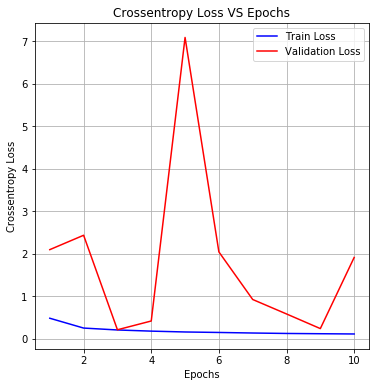

In [168]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

training_loss = history_1.history['loss']
validation_loss = history_1.history['val_loss']

model1_train_accuracy = max(history_1.history['acc'])
model1_test_accuracy = score[1]

epochs = list(range(1,11))

plot_loss(training_loss, validation_loss, epochs)


<h3> Model with 2 LSTM

In [173]:
embedding_vector_length = 32
# Creating the model
model = Sequential()

# Adding the embedding
model.add(Embedding(len(vocabulory.keys())+1, embedding_vector_length, input_length = max_review_length))
model.add(Dropout(0.5))

# Adding LSTM Layer
model.add(LSTM(100, return_sequences=True))

# Adding LSTM Layer
model.add(LSTM(100))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])

history_2 = model.fit(x_train, y_train, verbose=1, epochs=10, batch_size=128, validation_data = (x_test, y_test))

model.summary()

Train on 61441 samples, validate on 26332 samples
Epoch 1/10
61441/61441 [==============================] - 364s 6ms/step - loss: 0.2917 - acc: 0.8794 - val_loss: 0.3071 - val_acc: 0.8782
Epoch 2/10
61441/61441 [==============================] - 351s 6ms/step - loss: 0.1793 - acc: 0.9297 - val_loss: 0.2131 - val_acc: 0.9167
Epoch 3/10
61441/61441 [==============================] - 351s 6ms/step - loss: 0.1464 - acc: 0.9440 - val_loss: 1.5273 - val_acc: 0.4224
Epoch 4/10
61441/61441 [==============================] - 352s 6ms/step - loss: 0.1241 - acc: 0.9529 - val_loss: 0.2896 - val_acc: 0.9040
Epoch 5/10
61441/61441 [==============================] - 352s 6ms/step - loss: 0.1076 - acc: 0.9593 - val_loss: 0.2997 - val_acc: 0.9022
Epoch 6/10
61441/61441 [==============================] - 350s 6ms/step - loss: 0.0930 - acc: 0.9650 - val_loss: 0.2784 - val_acc: 0.8991
Epoch 7/10
61441/61441 [==============================] - 350s 6ms/step - loss: 0.0831 - acc: 0.9680 - val_loss: 0.4282 - 

Test Loss:  0.45850718044028643
Test Accuracy:  0.8621828953274184


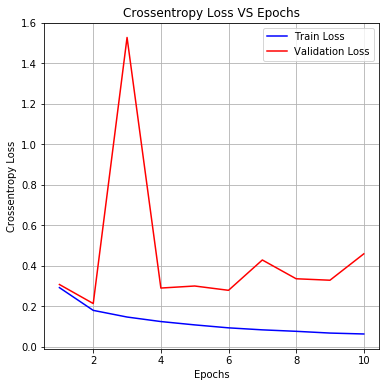

In [174]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

training_loss = history_2.history['loss']
validation_loss = history_2.history['val_loss']

model2_train_accuracy = max(history_2.history['acc'])
model2_test_accuracy = score[1]

epochs = list(range(1,11))

plot_loss(training_loss, validation_loss, epochs)

<h3> Model with 3 LSTM

In [175]:
embedding_vector_length = 32
# Creating the model
model = Sequential()

# Adding the embedding
model.add(Embedding(len(vocabulory)+1, embedding_vector_length, input_length = max_review_length))
model.add(Dropout(0.5))

# Adding LSTM Layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))

# Adding LSTM Layer
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.3))

# Adding LSTM Layer
model.add(LSTM(60))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])

history_3 = model.fit(x_train, y_train, verbose=1, epochs=10, batch_size=256, validation_data = (x_test, y_test))

model.summary()

Train on 61441 samples, validate on 26332 samples
Epoch 1/10
61441/61441 [==============================] - 384s 6ms/step - loss: 0.3550 - acc: 0.8541 - val_loss: 0.2217 - val_acc: 0.9137
Epoch 2/10
61441/61441 [==============================] - 378s 6ms/step - loss: 0.1948 - acc: 0.9255 - val_loss: 0.8331 - val_acc: 0.8416
Epoch 3/10
61441/61441 [==============================] - 375s 6ms/step - loss: 0.1559 - acc: 0.9418 - val_loss: 0.2306 - val_acc: 0.9198
Epoch 4/10
61441/61441 [==============================] - 377s 6ms/step - loss: 0.1317 - acc: 0.9515 - val_loss: 0.2964 - val_acc: 0.9075
Epoch 5/10
61441/61441 [==============================] - 377s 6ms/step - loss: 0.1142 - acc: 0.9578 - val_loss: 0.2594 - val_acc: 0.9115
Epoch 6/10
61441/61441 [==============================] - 374s 6ms/step - loss: 0.1002 - acc: 0.9637 - val_loss: 0.2747 - val_acc: 0.9031
Epoch 7/10
61441/61441 [==============================] - 374s 6ms/step - loss: 0.0904 - acc: 0.9673 - val_loss: 0.2794 - 

Test Loss:  0.6388203802451708
Test Accuracy:  0.8929059699134734


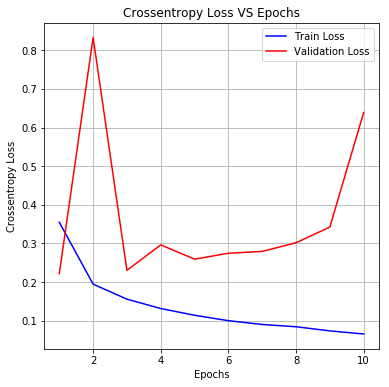

In [176]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

training_loss = history_3.history['loss']
validation_loss = history_3.history['val_loss']

model3_train_accuracy = max(history_3.history['acc'])
model3_test_accuracy = score[1]

epochs = list(range(1,11))

plot_loss(training_loss, validation_loss, epochs)

<h3>CONCLUSION</h3>

**(a). Procedure Followed :**
 
1.   Loaded Amazon food review dataset from Google Drive and selected 1 lakh records for analysis
2.   Perform text preprocessing
3.   Find vocabulory and frequency for each word  in dataset
4.   Ranked each word based on frequency
5.   Split the dataset for training and test
6.   Applied padding to make all reviews of same size i.e. 100
7.   Implemented LSTM with layers 1 , 2 and 3
8.   Plotted Crossentropy Loss VS No.of Epochs


In [182]:
from prettytable import PrettyTable
table = PrettyTable()
table.add_column("S. No.", [1,2,3])
table.add_column("Models", ["Model with 1 LSTM", "Model with 2 LSTM", "Model with 3 LSTM"])
table.add_column("Training Accuracy", [model1_train_accuracy, model2_train_accuracy, model3_train_accuracy])
table.add_column("Test Accuracy", [model1_test_accuracy, model2_test_accuracy, model3_test_accuracy])
print(table)

+--------+-------------------+--------------------+--------------------+
| S. No. |       Models      | Training Accuracy  |   Test Accuracy    |
+--------+-------------------+--------------------+--------------------+
|   1    | Model with 1 LSTM | 0.9592942823196237 | 0.8390171654351518 |
|   2    | Model with 2 LSTM | 0.9762861932585732 | 0.8621828953274184 |
|   3    | Model with 3 LSTM | 0.976204814374766  | 0.8929059699134734 |
+--------+-------------------+--------------------+--------------------+
